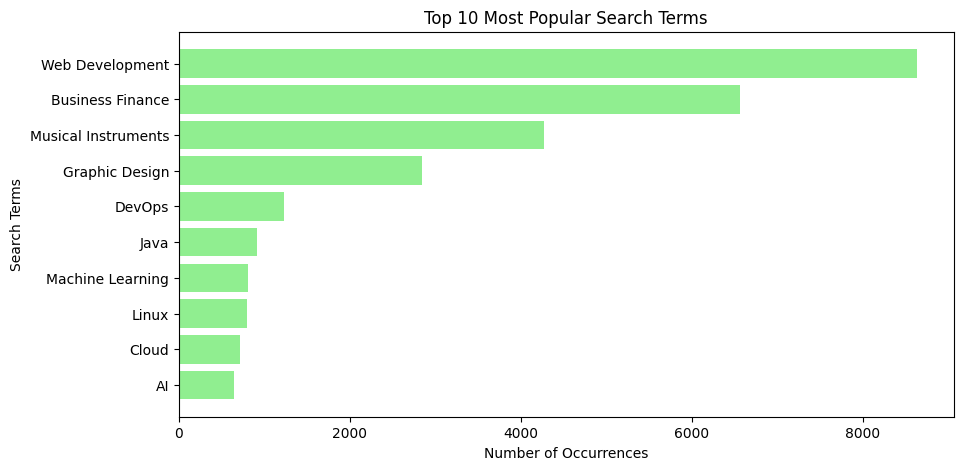

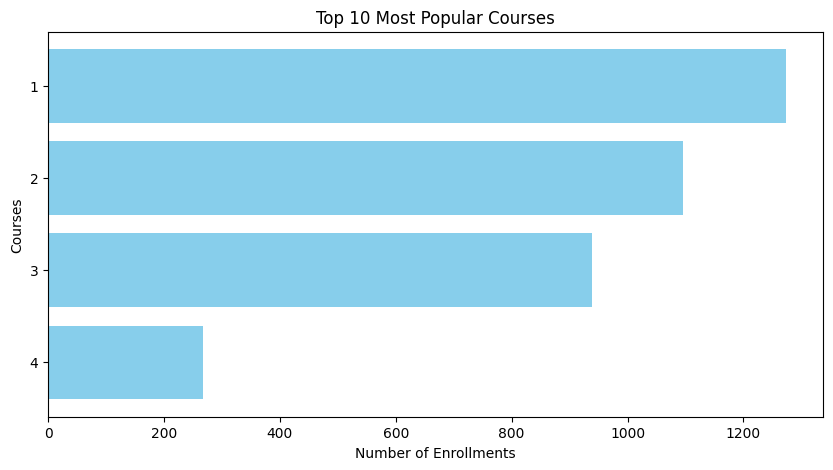

In [4]:
import redis
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


def read_csv(csv_file):
    data = pd.read_csv(csv_file)
    return data.to_dict(orient='records')
r = redis.StrictRedis(host='localhost', port=6379, decode_responses=True)

def import_data_to_redis( universities_csv, courses_csv, students_csv, searches_csv, enrollment_csv):
    

    universities_data = read_csv(universities_csv)
    courses_data = read_csv(courses_csv)
    students_data = read_csv(students_csv)
    searches_data = read_csv(searches_csv)
    enrollment_data = read_csv(enrollment_csv)

    for uni in universities_data:
        r.hset(f"university:{uni['id']}", mapping=uni)


    for course in courses_data:
        r.hset(f"course:{course['id']}", mapping=course)
        r.sadd(f"university:{course['uni']}:courses", course['id'])


    for student in students_data:
        r.hset(f"student:{student['id']}", mapping=student)

  
    for search in searches_data:
        search_id = search['id']
        student_id = search['user']
        r.hset(f"search:{search_id}", mapping=search)
        r.sadd(f"student:{student_id}:searches", search_id)
        r.zincrby("search_counts", 1, search['words'])


    for enroll in enrollment_data:
        student_id = enroll['student.id']
        course_id = enroll['course.id']
        r.hset(f"enrollment:{student_id}:{course_id}", mapping=enroll)
        r.sadd(f"student:{student_id}:enrollments", course_id)
        r.sadd(f"course:{course_id}:students", student_id)

 
    most_popular_searches = r.zrevrange("search_counts", 0, 9, withscores=True)

 
    course_student_counts = Counter()
    for course_id in r.keys("course:*:students"):
        course_student_counts[course_id.split(":")[1]] = r.scard(course_id)
    most_popular_courses = course_student_counts.most_common(10)

    return most_popular_searches, most_popular_courses


def plot_results(most_popular_searches, most_popular_courses):
    if most_popular_searches:
        '''
        print("The most popular search terms are:")
        for term, count in most_popular_searches:
            print(f"{term}: {count} occurrences")
        '''
    
        search_terms = [term for term, count in most_popular_searches]
        occurrences = [count for term, count in most_popular_searches]

        plt.figure(figsize=(10, 5))
        plt.barh(search_terms, occurrences, color='lightgreen')
        plt.xlabel('Number of Occurrences')
        plt.ylabel('Search Terms')
        plt.title('Top 10 Most Popular Search Terms')
        plt.gca().invert_yaxis()
        plt.show()
    
    if most_popular_courses:
        '''
        print("The most popular courses are:")
        
        for course, enrollments in most_popular_courses:
            print(f"Course ID {course}: {enrollments} enrollments")
        '''
       
        courses = [course for course, enrollments in most_popular_courses]
        enrollments = [enrollments for course, enrollments in most_popular_courses]

        plt.figure(figsize=(10, 5))
        plt.barh(courses, enrollments, color='skyblue')
        plt.xlabel('Number of Enrollments')
        plt.ylabel('Courses')
        plt.title('Top 10 Most Popular Courses')
        plt.gca().invert_yaxis()
        plt.show()


universities_csv = "univ.csv"
courses_csv = "course.csv"
students_csv = "student.csv"
searches_csv = "search.csv"
enrollment_csv = "enrollement.csv"


most_popular_searches, most_popular_courses = import_data_to_redis( universities_csv, courses_csv, students_csv, searches_csv, enrollment_csv)


plot_results(most_popular_searches, most_popular_courses)
